In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D,Flatten, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def get_data_generators():
    train_dir = '/kaggle/input/private-datasetrar/227x227/train'
    valid_dir = '/kaggle/input/private-datasetrar/227x227/valid'
    test_dir = '/kaggle/input/private-datasetrar/227x227/test'

    batch_size = 32
    img_height, img_width = (227, 227)

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.4
    )
    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    valid_generator = train_datagen.flow_from_directory(
        directory=valid_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation'
    )
    test_generator = train_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, valid_generator, test_generator


In [3]:
def AlexNet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # First convolutional layer
    X = Conv2D(filters=96, kernel_size=(11, 11), strides=4, activation='relu', padding="same")(input_layer)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # Second convolutional layer
    X = Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding="same")(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # Third convolutional layer
    X = Conv2D(filters=384, kernel_size=(3, 3), strides=1, activation='relu', padding="same")(X)
    X = BatchNormalization()(X)

    # Fourth convolutional layer
    X = Conv2D(filters=384, kernel_size=(3, 3), strides=1, activation='relu', padding="same")(X)
    X = BatchNormalization()(X)

    # Fifth convolutional layer
    X = Conv2D(filters=256, kernel_size=(3, 3), strides=1, activation='relu', padding="same")(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # Flattening
    X = Flatten()(X)

    # First fully connected layer
    X = Dense(4096, activation='relu')(X)
    X = Dropout(0.5)(X)

    # Second fully connected layer
    X = Dense(4096, activation='relu')(X)
    X = Dropout(0.5)(X)

    # Output layer
    predictions = Dense(num_classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs=input_layer, outputs=predictions, name="AlexNet")
    return model


In [4]:
def compile_and_fit_model(model, train_generator, valid_generator):
    EPOCHS = 50
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_filepath_best = '/kaggle/working/Alexnet/50epoch.{epoch:02d}-{val_loss:.2f}.h5'
    checkpoint_best = ModelCheckpoint(
        filepath=checkpoint_filepath_best,
        save_best_only=True,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=valid_generator,
        callbacks=[checkpoint_best]
    )
    return history


In [5]:
def plot_training_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    # Plot Training Accuracy and Validation Accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('AlexNet Training Accuracy VS Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['Training', 'Validation'])

    # Plot Training Loss and Validation Loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('AlexNet Training Loss VS Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['Training', 'Validation'])

    plt.tight_layout()
    plt.show()


In [6]:
def save_best_model():
    saved_models_dir = '/kaggle/working/Alexnet/'
    saved_model_files = glob.glob(os.path.join(saved_models_dir, '*.h5'))
    saved_model_files.sort()
    best_model_file = saved_model_files[-1]
    best_model = tf.keras.models.load_model(best_model_file)

    best_model.save('/kaggle/working/Alexnet/Best_AlexNet.h5')


In [7]:
def evaluate_models(test_generator, train_generator):
    saved_model_filepaths = glob.glob('/kaggle/working/Alexnet/*.h5')

    for model_filepath in saved_model_filepaths:
        print("Model file path: {}".format(model_filepath))

        model = tf.keras.models.load_model(model_filepath)

        filenames = test_generator.filenames
        nb_samples = len(filenames)

        y_prob = []
        y_act = []

        test_generator.reset()
        for _ in range(nb_samples):
            X_test, Y_test = test_generator.next()
            y_prob.append(model.predict(X_test))
            y_act.append(Y_test)

        predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
        actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

        out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

        confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

        sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
        plt.title('Confusion Matrix for Model: {}'.format(model_filepath))
        plt.show()

        print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100)))


Found 1593 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 9.3634 - accuracy: 0.5304
Epoch 1: val_accuracy improved from -inf to 0.49891, saving model to /kaggle/working/Alexnet/50epoch.01-9.09.h5
50/50 [==============================] - 46s 651ms/step - loss: 9.3634 - accuracy: 0.5304 - val_loss: 9.0904 - val_accuracy: 0.4989
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 1.0532 - accuracy: 0.5537
Epoch 2: val_accuracy improved from 0.49891 to 0.50109, saving model to /kaggle/working/Alexnet/50epoch.02-0.86.h5
50/50 [==============================] - 26s 513ms/step - loss: 1.0532 - accuracy: 0.5537 - val_loss: 0.8559 - val_accuracy: 0.5011
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.8382 - accuracy: 0.5700
Epoch 3: val_accuracy improved from 0.50109 to 0.50766, saving model to /kaggle/working/Alexnet/50epoch

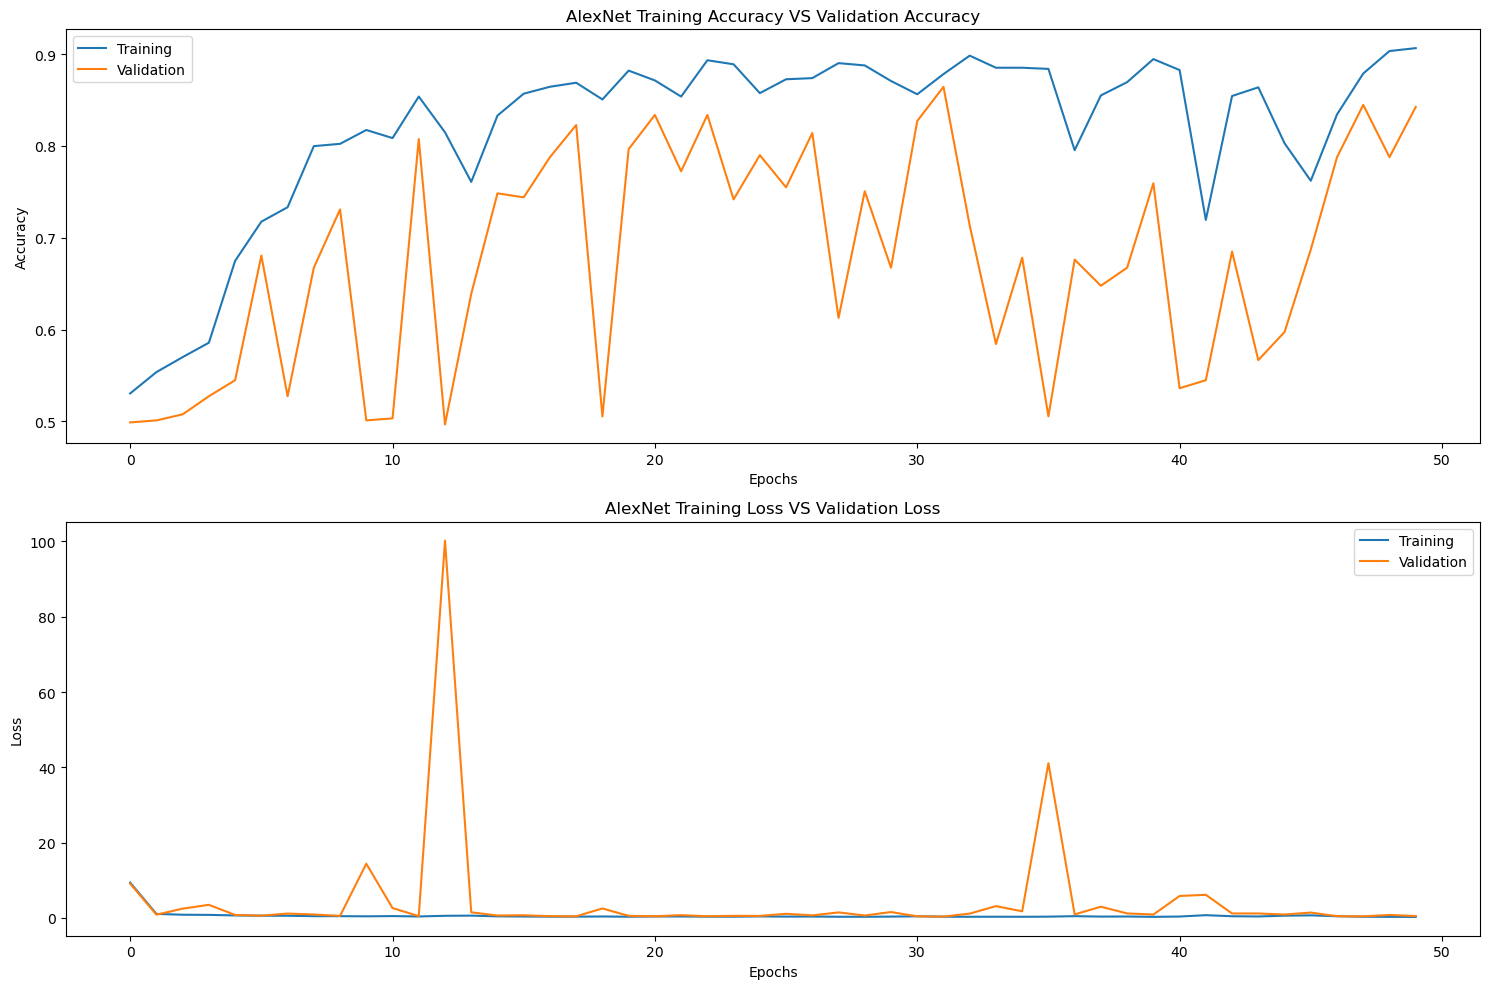

Model file path: /kaggle/working/Alexnet/50epoch.32-0.34.h5
1/1 [==============================] - 0s 19ms/step


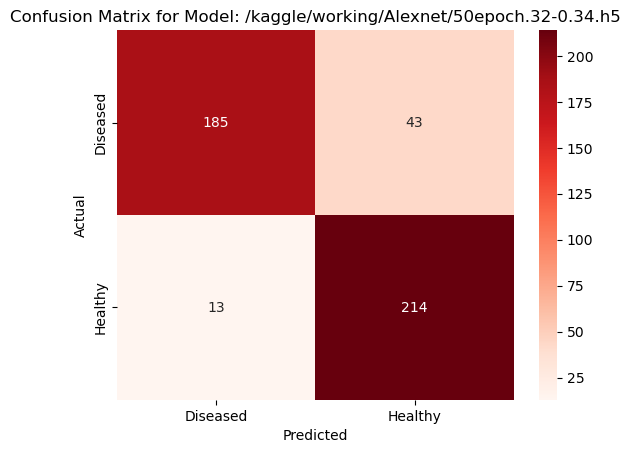

Test accuracy: 87.6923076923077
Model file path: /kaggle/working/Alexnet/50epoch.12-0.47.h5
1/1 [==============================] - 0s 18ms/step


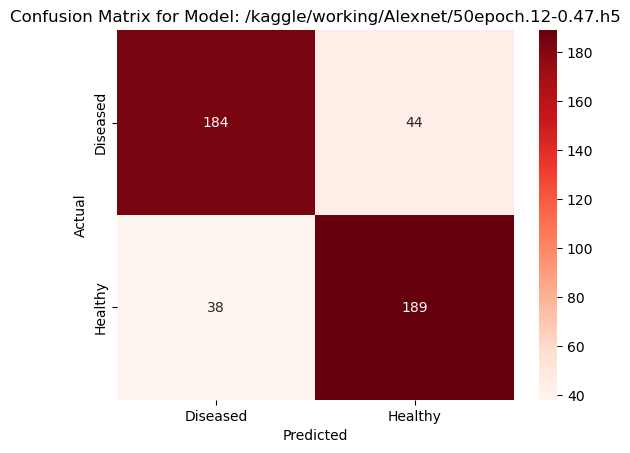

Test accuracy: 81.97802197802197
Model file path: /kaggle/working/Alexnet/Best_AlexNet.h5
1/1 [==============================] - 0s 21ms/step


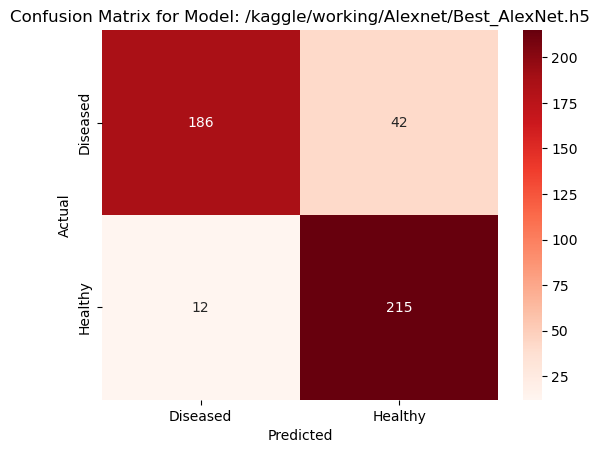

Test accuracy: 88.13186813186813
Model file path: /kaggle/working/Alexnet/50epoch.06-0.60.h5
1/1 [==============================] - 0s 21ms/step


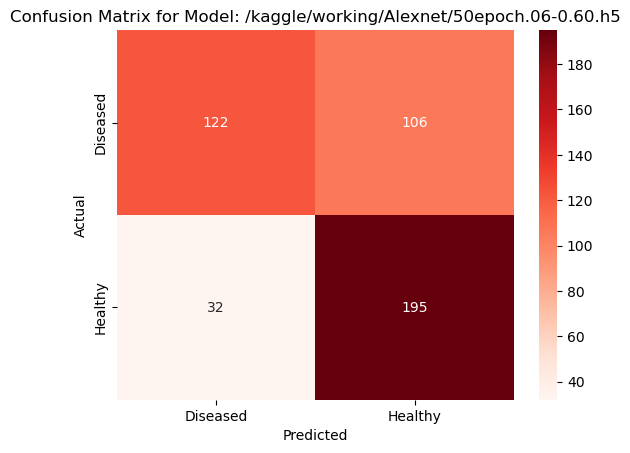

Test accuracy: 69.67032967032966
Model file path: /kaggle/working/Alexnet/50epoch.09-0.53.h5
1/1 [==============================] - 0s 18ms/step


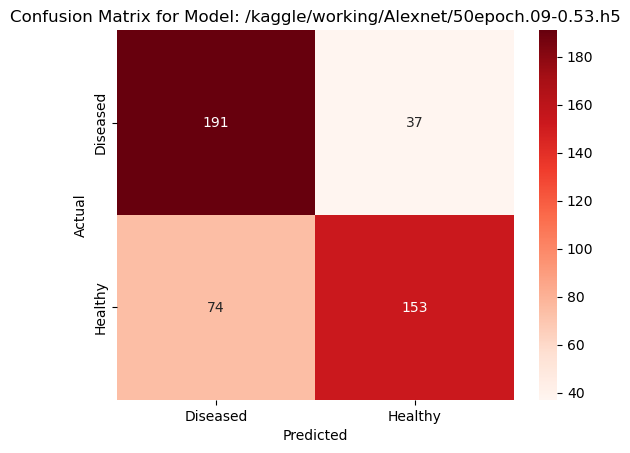

Test accuracy: 75.6043956043956
Model file path: /kaggle/working/Alexnet/50epoch.03-2.45.h5
1/1 [==============================] - 0s 19ms/step


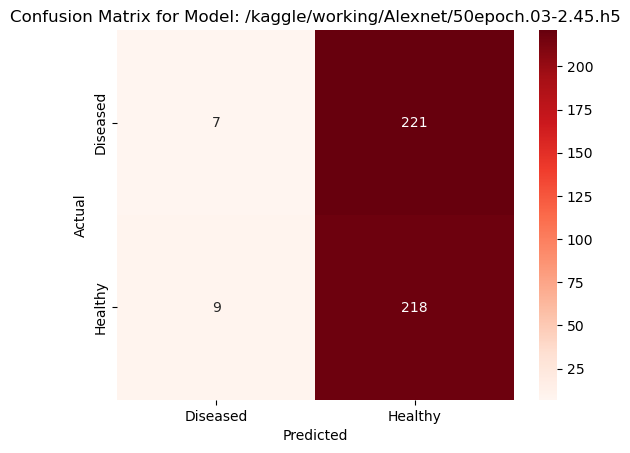

Test accuracy: 49.45054945054945
Model file path: /kaggle/working/Alexnet/50epoch.04-3.46.h5
1/1 [==============================] - 0s 19ms/step


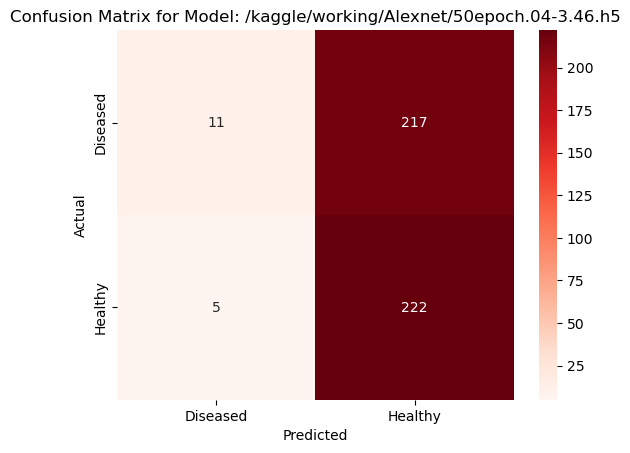

Test accuracy: 51.208791208791204
Model file path: /kaggle/working/Alexnet/50epoch.01-9.09.h5
1/1 [==============================] - 0s 18ms/step


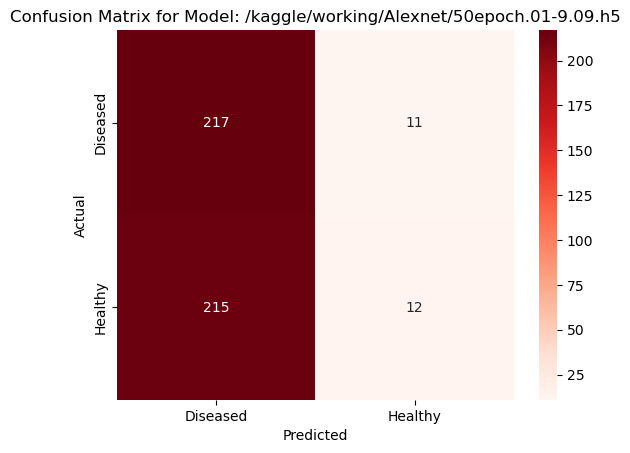

Test accuracy: 50.32967032967033
Model file path: /kaggle/working/Alexnet/50epoch.21-0.43.h5
1/1 [==============================] - 0s 30ms/step


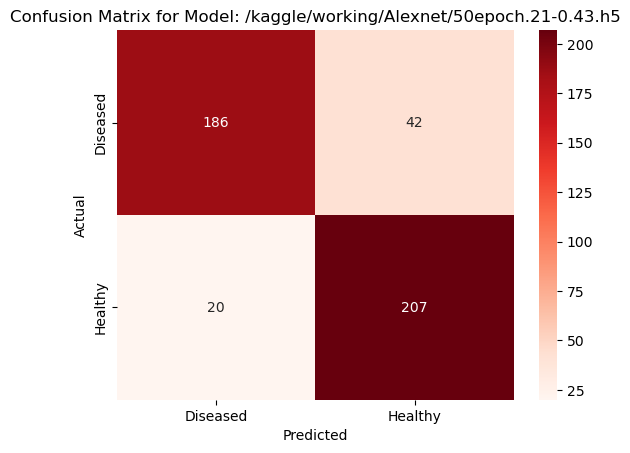

Test accuracy: 86.37362637362638
Model file path: /kaggle/working/Alexnet/50epoch.18-0.42.h5
1/1 [==============================] - 0s 18ms/step


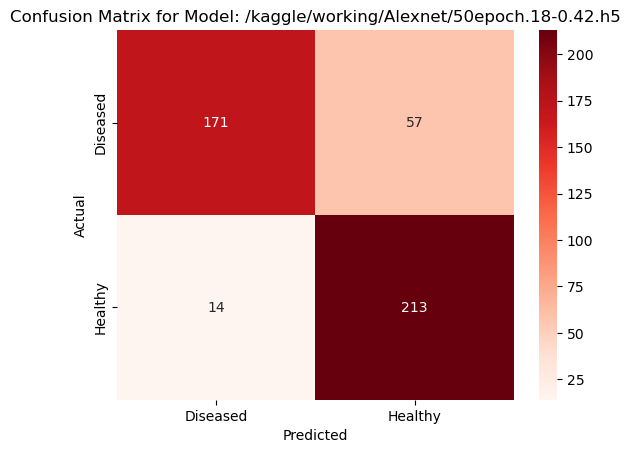

Test accuracy: 84.3956043956044
Model file path: /kaggle/working/Alexnet/50epoch.02-0.86.h5
1/1 [==============================] - 0s 29ms/step


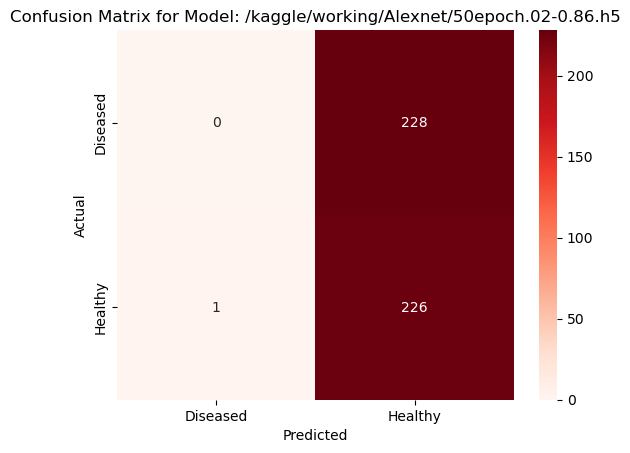

Test accuracy: 49.67032967032967
Model file path: /kaggle/working/Alexnet/50epoch.05-0.78.h5
1/1 [==============================] - 0s 21ms/step


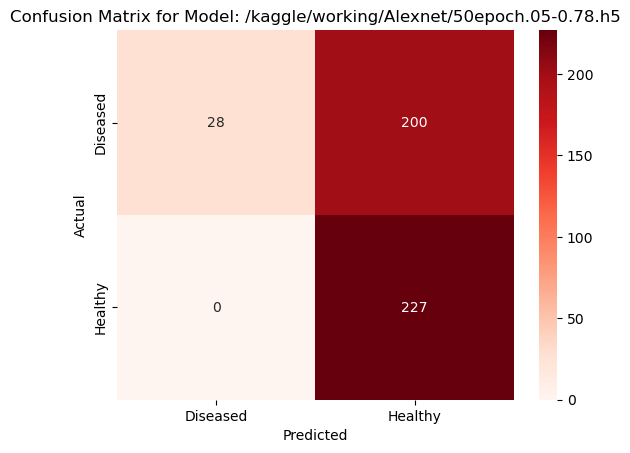

Test accuracy: 56.043956043956044


In [8]:
def main():
    train_generator, valid_generator, test_generator = get_data_generators()
    model = AlexNet(train_generator.image_shape, train_generator.num_classes)
    history = compile_and_fit_model(model, train_generator, valid_generator)
    plot_training_history(history)
    save_best_model()
    evaluate_models(test_generator, train_generator)

if __name__ == "__main__":
    main()
